[Part I: On-policy learning and SARSA](#Part-I:-On-policy-learning-and-SARSA)

[Part II: Experience replay](#Part-II:-experience-replay)

## Part I: On-policy learning and SARSA

_This notebook builds upon `003-q-learning.ipynb`, or to be exact your implementation of QLearningAgent._

The policy we're gonna use is epsilon-greedy policy, where agent takes optimal action with probability $(1-\epsilon)$, otherwise samples action at random. Note that agent __can__ occasionally sample optimal action during random sampling by pure chance.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

You can copy your `QLearningAgent` implementation from previous notebook.

In [1]:
from collections import defaultdict
import random
import math
import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value

        Note: please avoid using self._qValues directly.
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        possible_actions = self.get_legal_actions(state)
        if len(possible_actions) == 0:
            return 0.0
        value = max(self.get_qvalue(state, action) for action in possible_actions)
        return value

    def update(self, state, action, reward, next_state):
        gamma = self.discount
        alpha = self.alpha
        q_current = self.get_qvalue(state, action)
        next_value = self.get_value(next_state)
        q_new = (1 - alpha) * q_current + alpha * (reward + gamma * next_value)
        self.set_qvalue(state, action, q_new)

    def get_best_action(self, state):
        possible_actions = self.get_legal_actions(state)
        if len(possible_actions) == 0:
            return None
        best_action = max(possible_actions, key=lambda a: self.get_qvalue(state, a))
        return best_action

    def get_action(self, state):
        possible_actions = self.get_legal_actions(state)
        if len(possible_actions) == 0:
            return None
        if random.random() < self.epsilon:
            chosen_action = random.choice(possible_actions)
        else:
            chosen_action = self.get_best_action(state)
        return chosen_action

Now we gonna implement Expected Value SARSA on top of it.

In [2]:
class EVSarsaAgent(QLearningAgent):
    """
    An agent that changes some of q-learning functions to implement Expected Value SARSA.
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for Expected Value SARSA's V(s')
    """

    def get_value(self, state):
        epsilon = self.epsilon
        possible_actions = self.get_legal_actions(state)
        if len(possible_actions) == 0:
            return 0.0

        n = len(possible_actions)
        best_action = self.get_best_action(state)
        state_value = 0.0

        for a in possible_actions:
            pi_a = epsilon / n
            if a == best_action:
                pi_a += (1 - epsilon)
            q_val = self.get_qvalue(state, a)
            state_value += pi_a * q_val

        return state_value

### Cliff World

Let's now see how our algorithm compares against q-learning in case where we force agent to explore all the time.

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/cliffworld.png width=600>
<center><i>image by cs188</i></center>

In [3]:
import gym
import gym.envs.toy_text
env = gym.envs.toy_text.CliffWalkingEnv()
n_actions = env.action_space.n

print(env.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf

    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    


In [4]:
# Our cliffworld has one difference from what's on the image: there is no wall.
# Agent can choose to go as close to the cliff as it wishes. x:start, T:exit, C:cliff, o: flat ground
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [5]:
def play_and_train(env, agent, t_max=10**4):
    """This function should
    - run a full game, actions given by agent.get_action(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [6]:
agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                           get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))

EVSARSA mean reward = -25.46
QLEARNING mean reward = -97.45


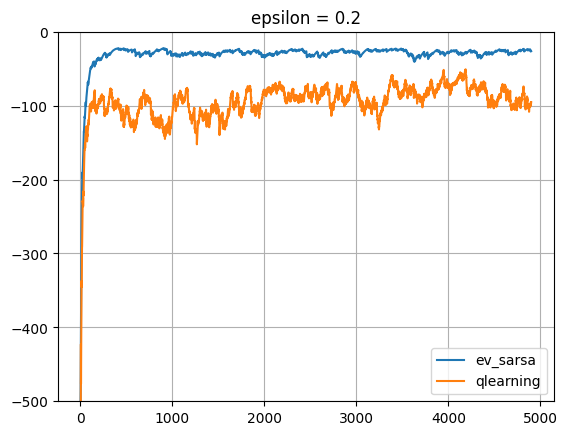

In [8]:
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt

def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 100 == 0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

Let's now see what did the algorithms learn by visualizing their actions at every state.

In [9]:
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape

    actions = '^>v<'

    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.get_best_action(yi * n_cols + xi)], end='')
        print()

In [10]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

Q-Learning
 v  >  >  >  v  >  >  >  v  v  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


### More on SARSA

Here are some of the things you can do if you feel like it:

* Play with epsilon. See learned how policies change if you set epsilon to higher/lower values (e.g. 0.75).
* Expected Value SARSA for softmax policy __(2pts)__:
$$ \pi(a_i \mid s) = \operatorname{softmax} \left( \left\{ {Q(s, a_j) \over \tau} \right\}_{j=1}^n \right)_i = {\operatorname{exp} \left( Q(s,a_i) / \tau \right)  \over {\sum_{j}  \operatorname{exp} \left( Q(s,a_j) / \tau  \right)}} $$
* Implement N-step algorithms and TD($\lambda$): see [Sutton's book](http://incompleteideas.net/book/RLbook2020.pdf) chapter 7 and chapter 12.
* Use those algorithms to train on CartPole in previous / next assignment for this week.

## Part II: Experience Replay

There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: [spoiler] Experience replay :)

The catch is that you can train Q-learning and EV-SARSA on `<s,a,r,s'>` tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=480>

#### Training with experience replay
1. Play game, sample `<s,a,r,s'>`.
2. Update q-values based on `<s,a,r,s'>`.
3. Store `<s,a,r,s'>` transition in a buffer. 
 3. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.


To enable such training, first we must implement a memory structure that would act like such a buffer.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

In [12]:
class ReplayBuffer(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)
        if len(self._storage) >= self._maxsize:
            self._storage.pop(0)  # remove oldest
        self._storage.append(data)

    def sample(self, batch_size):
        idxes = random.choices(range(len(self._storage)), k=batch_size)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in idxes:
            s, a, r, s1, d = self._storage[i]
            states.append(s)
            actions.append(a)
            rewards.append(r)
            next_states.append(s1)
            dones.append(d)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones),
        )


Some tests to make sure your buffer works right

In [13]:
def obj2arrays(obj):
    for x in obj:
        yield np.array([x])

def obj2sampled(obj):
    return tuple(obj2arrays(obj))

replay = ReplayBuffer(2)
obj1 = (0, 1, 2, 3, True)
obj2 = (4, 5, 6, 7, False)
replay.add(*obj1)
assert replay.sample(1) == obj2sampled(obj1), \
    "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay) == 2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay) == 2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2sampled(obj2)
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100)) == 2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2sampled(obj1)
print("Success!")

Success!


Now let's use this buffer to improve training:

In [15]:
import gym
env = gym.make("Taxi-v2")
n_actions = env.action_space.n

In [16]:
def play_and_train_with_replay(
    env, agent, replay=None, t_max=10**4, replay_batch_size=32
):
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.get_action(s)
        next_s, r, done, _ = env.step(a)

        agent.update(s, a, r, next_s)

        if replay is not None:
            replay.add(s, a, r, next_s, done)
            if len(replay) >= replay_batch_size:
                s_batch, a_batch, r_batch, ns_batch, done_batch = replay.sample(
                    replay_batch_size
                )
                for i in range(replay_batch_size):
                    agent.update(s_batch[i], a_batch[i], r_batch[i], ns_batch[i])

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward


In [17]:
# Create two agents: first will use experience replay, second will not.

agent_baseline = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

agent_replay = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

replay = ReplayBuffer(1000)

Baseline : eps = 2.9191091959171894e-05 mean reward = 8.5
ExpReplay: eps = 2.9191091959171894e-05 mean reward = 7.7


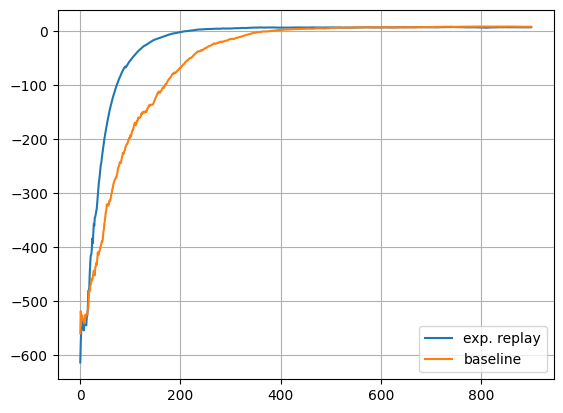

In [18]:
from IPython.display import clear_output
import pandas as pd

def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

rewards_replay, rewards_baseline = [], []

for i in range(1000):
    rewards_replay.append(
        play_and_train_with_replay(env, agent_replay, replay))
    rewards_baseline.append(
        play_and_train_with_replay(env, agent_baseline, replay=None))

    agent_replay.epsilon *= 0.99
    agent_baseline.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        print('Baseline : eps =', agent_replay.epsilon,
              'mean reward =', np.mean(rewards_baseline[-10:]))
        print('ExpReplay: eps =', agent_baseline.epsilon,
              'mean reward =', np.mean(rewards_replay[-10:]))
        plt.plot(moving_average(rewards_replay), label='exp. replay')
        plt.plot(moving_average(rewards_baseline), label='baseline')
        plt.grid()
        plt.legend()
        plt.show()

#### What to expect:

Experience replay, if implemented correctly, will improve algorithm's initial convergence a lot, but it shouldn't affect the final performance.